# Lead Score Case Study

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Preparation and Inspection

In [2]:
data = pd.read_csv("Leads.csv")
data.shape

(9240, 37)

In [3]:
data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
data.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [6]:
print(data.duplicated(subset = "Prospect ID").sum() == 0)
print()
print(data.duplicated(subset = "Lead Number").sum() == 0)

True

True


**Inference :**
- Both the Prospect ID & Lead Number have no duplicate entries

In [7]:
print(round(100 * data.isnull().sum()/len(data),2))

#Columns with Non-null entries
columns_with_NA = sum(round(100 * data.isnull().sum()/len(data),2)>0)
print("\nNumber of Non-Null Columns : ", len(data.columns) - columns_with_NA)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [8]:
obj_vars = data.select_dtypes("object").columns

for i in obj_vars:
    print(data[i].value_counts())
    print()

7927b2df-8bba-4d29-b9a2-b6e0beafe620    1
22e9d4ef-d294-4ebf-81c7-7c7a1105aeea    1
46befc49-253a-419b-abea-2fd978d2e2b1    1
9d35a2c2-09d8-439f-9875-0e8bbf267f5a    1
f0de9371-4dc2-48c2-9785-a08d6fc4fcb5    1
                                       ..
ff1f7582-cb7b-4b94-9cdc-3d0d0afdd9a3    1
644099a2-3da4-4d23-9546-7676340a372b    1
2a093175-415b-4321-9e69-ed8d9df65a3c    1
c66249a3-8500-4c66-a511-312d914573de    1
571b5c8e-a5b2-4d57-8574-f2ffb06fdeff    1
Name: Prospect ID, Length: 9240, dtype: int64

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Releas

**Inference :**
- In some non-numeric fields `Select` is given as mandatory entry
- Replace them with nAN

In [9]:
df = data.copy()

df = df.replace("Select", np.nan)

In [10]:
round(100 * df.isnull().sum()/len(df),2).sort_values(ascending = False)

How did you hear about X Education               78.46
Lead Profile                                     74.19
Lead Quality                                     51.59
Asymmetrique Profile Score                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Index                       45.65
City                                             39.71
Specialization                                   36.58
Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Receive More Updates About Our Courses            0.00
I agree to

**Inference :**
- Many columns have more than 45% of missing entries
- We'll drop those columns for further analysis

In [11]:
#Columns with more 45% of null entries
drop_cols = round(100 * df.isnull().sum()/len(df),2) > 45
drop_cols = drop_cols[drop_cols == True].index

# Dropping those columns
df.drop(drop_cols, axis = 1, inplace = True)

#### Missing Value Percentage after dropping of columns

In [12]:
round(100 * df.isnull().sum()/len(df),2).sort_values(ascending = False)

City                                             39.71
Specialization                                   36.58
Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Through Recommendations                           0.00
Receive More Updates About Our Courses            0.00
Prospect ID                                       0.00
Newspaper                                         0.00
Update me on Supply Chain Content                 0.00
Get updates on DM Content                         0.00
I agree to pay the amount through cheque          0.00
A free copy of Mastering The Interview            0.00
Digital Ad

In [13]:
df["City"].value_counts(dropna = False)

NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

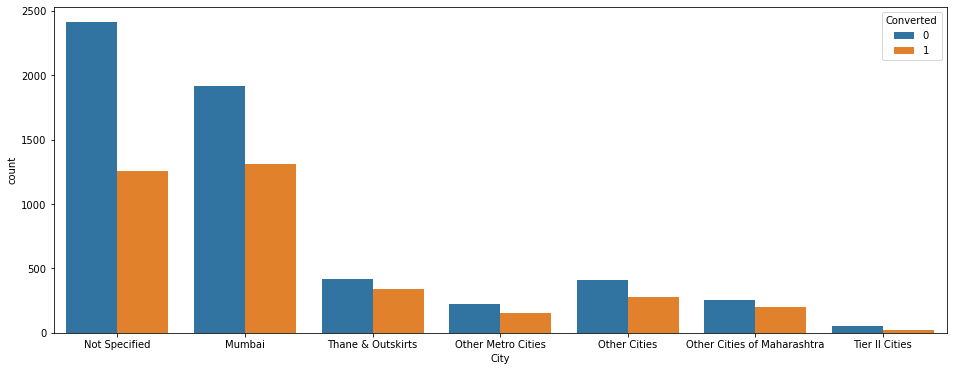

In [14]:
df["City"].replace(np.nan, "Not Specified", inplace = True)

plt.figure(figsize = (16,6))
sns.countplot(data = df, x = "City", hue = "Converted")
plt.xticks(rotation = 0)
plt.show()

**Inference :**
- As we could see from the chart almost all the cities belong to Maharashtra
- Other Cities contribute relatively lower compared to the overall customer count.
- **So we'll drop this variable.**

In [15]:
df["Specialization"].value_counts(dropna = False)

NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [16]:
df["Specialization"].replace(np.nan, "Not Specified", inplace = True)

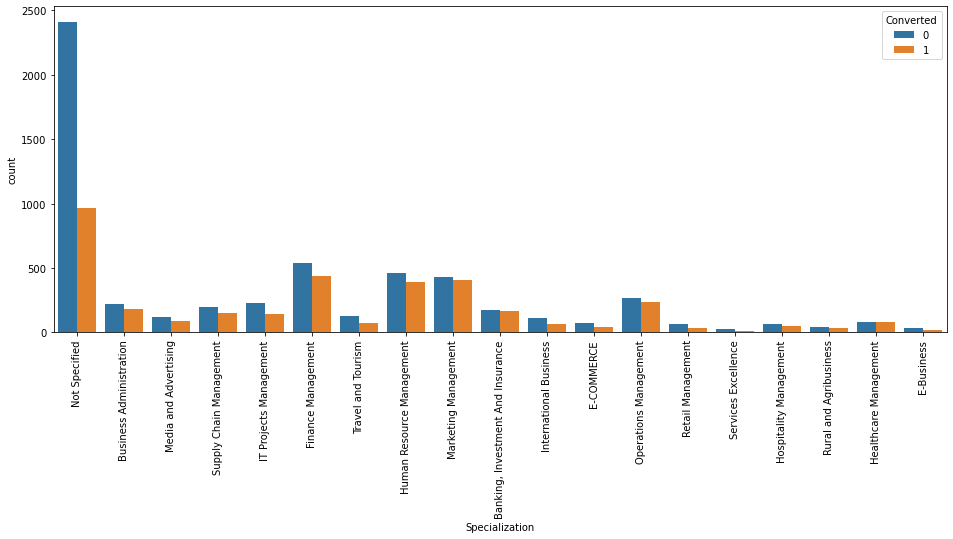

In [17]:
plt.figure(figsize = (16,6))
sns.countplot(data = df, x = "Specialization", hue = "Converted")
plt.xticks(rotation = 90)
plt.show()

**Inference :**
- There are various categories of management listed in the Specialization feature
- Also all the management level specializations have a good conversion ratio
- Hence we wont drop those but we'll categorize them into a single variable

In [18]:
mgmt = []

for i in df["Specialization"].unique():
    if "Management" in i:
        mgmt.append(i)
        
df["Specialization"].replace(mgmt, "Management", inplace = True)

In [19]:
df["Tags"].value_counts(dropna = False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

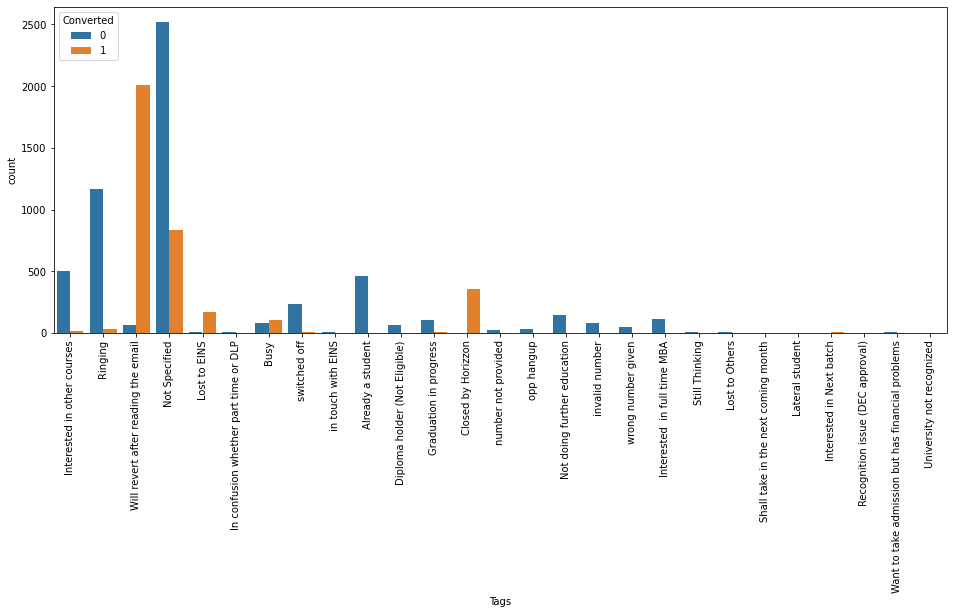

In [20]:
df["Tags"].replace(np.nan, "Not Specified", inplace = True)

plt.figure(figsize = (16,6))
sns.countplot(data = df, x = "Tags", hue = "Converted")
plt.xticks(rotation = 90)
plt.show()

**Inference :**
- Lead generation & Conversion Rate are high through 'Will revert after reading the email’. So We can focus on sending email)
- We'll categorize the low frequency labels into a single label.

In [21]:
df["What matters most to you in choosing a course"].value_counts(dropna = False)

Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

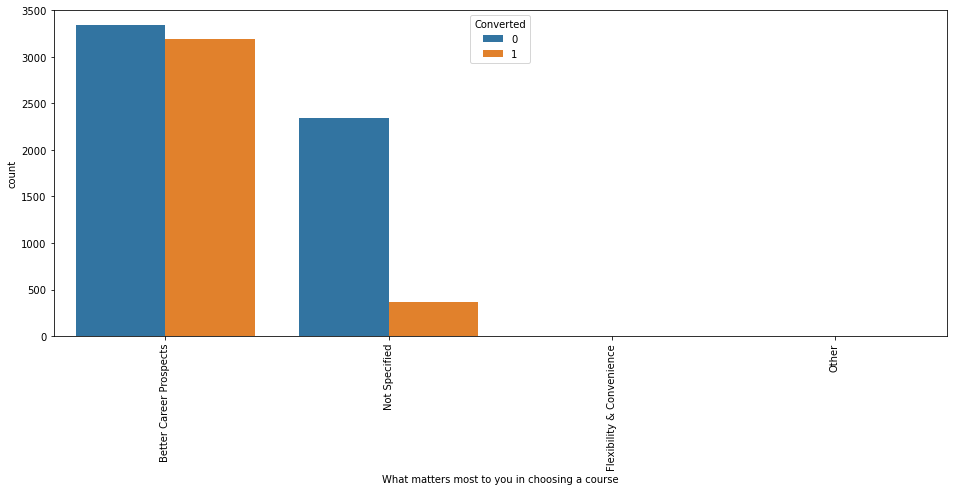

In [22]:
df["What matters most to you in choosing a course"].replace(np.nan, "Not Specified", inplace = True)

plt.figure(figsize = (16,6))
sns.countplot(data = df, x = "What matters most to you in choosing a course", hue = "Converted")
plt.xticks(rotation = 90)
plt.show()

**Inference :**
- The variable does not seem to add any value to the model
- **So we'll drop this variable.**

In [23]:
df['What is your current occupation'].value_counts(dropna = False)

Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

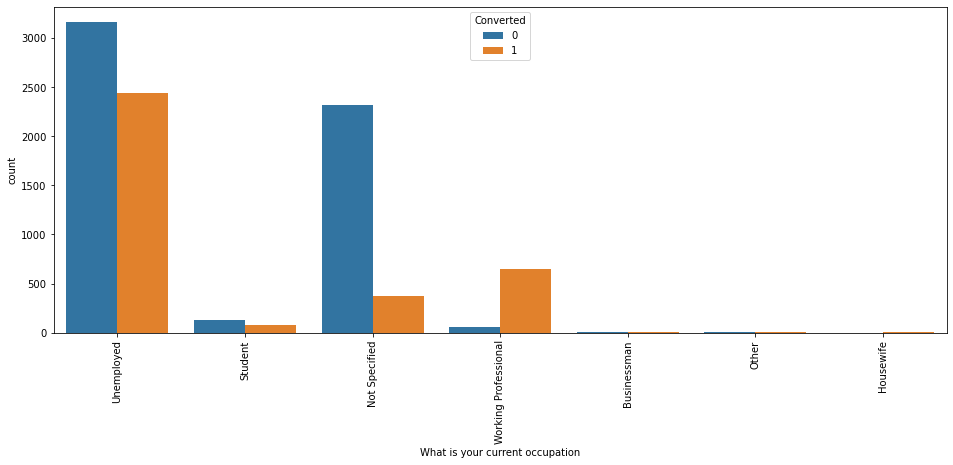

In [24]:
df['What is your current occupation'].replace(np.nan, "Not Specified", inplace = True)

plt.figure(figsize = (16,6))
sns.countplot(data = df, x = "What is your current occupation", hue = "Converted")
plt.xticks(rotation = 90)
plt.show()

**Inference :**
- Unemployed conversion is very high & some portion of working profession also converting from lead.
- There seems to be some pattern of conversion in this variable.For now we'll preoceed with this variable

In [25]:
df["Country"].value_counts(dropna = False)

India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switzerland   

**Inference :**
- Country variable is largely imbalanced as majority of the customers are from India.
- **So we'll drop this column**

In [26]:
list_of_dropcols = ["City", "What matters most to you in choosing a course", "Country"]

df.drop(list_of_dropcols, axis = 1, inplace = True)

In [27]:
round(100 * df.isnull().sum()/len(df),2).sort_values(ascending = False)

TotalVisits                                 1.48
Page Views Per Visit                        1.48
Last Activity                               1.11
Lead Source                                 0.39
Prospect ID                                 0.00
X Education Forums                          0.00
A free copy of Mastering The Interview      0.00
I agree to pay the amount through cheque    0.00
Get updates on DM Content                   0.00
Update me on Supply Chain Content           0.00
Tags                                        0.00
Receive More Updates About Our Courses      0.00
Through Recommendations                     0.00
Digital Advertisement                       0.00
Newspaper                                   0.00
Search                                      0.00
Newspaper Article                           0.00
Magazine                                    0.00
Lead Number                                 0.00
What is your current occupation             0.00
Specialization      

**Inference :**
- We have four more variables with null entries accounting to less than 2% of the total number of rows
- We'll drop those rows.

In [28]:
df.dropna(inplace = True)
df.isnull().sum()

Prospect ID                                 0
Lead Number                                 0
Lead Origin                                 0
Lead Source                                 0
Do Not Email                                0
Do Not Call                                 0
Converted                                   0
TotalVisits                                 0
Total Time Spent on Website                 0
Page Views Per Visit                        0
Last Activity                               0
Specialization                              0
What is your current occupation             0
Search                                      0
Magazine                                    0
Newspaper Article                           0
X Education Forums                          0
Newspaper                                   0
Digital Advertisement                       0
Through Recommendations                     0
Receive More Updates About Our Courses      0
Tags                              

In [29]:
object_cols = list(df.select_dtypes("object").columns)
object_cols.remove("Prospect ID")

In [30]:
for j in object_cols:
    print(df[j].value_counts())
    print()

Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: Lead Origin, dtype: int64

Google               2868
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference             443
Welingak Website      129
Referral Sites        125
Facebook               31
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

No     8358
Yes     716
Name: Do Not Email, dtype: int64

No     9072
Yes       2
Name: Do Not Call, dtype: int64

Email Opened                    3432
SMS Sent                        2716
Olark Chat Conversation          972
Page Visited on Website          6

**Inference :**
The following features seems to have high imbalance (i.e) more proportion on any one of the labels
- Do Not Call
- Search
- Magazine
- Newspaper Article
- X Education Forums
- Newspaper
- Digital Advertisement
- Through Recommendations
- Receive More Updates About Our Courses
- Update me on Supply Chain Content
- Get updates on DM Content
- I agree to pay the amount through cheque

So we'll remove these variables

In [31]:
add_drop_cols = ["Do Not Call","Search", "Magazine", "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement",
                 "Through Recommendations", "Receive More Updates About Our Courses", "Update me on Supply Chain Content",
                 "Get updates on DM Content", "I agree to pay the amount through cheque"]

df.drop(add_drop_cols, axis = 1, inplace = True)

#### Bivariate Analysis on Categorical Analysis

In [32]:
def countplot(i, rotation = 90):
    plt.figure(figsize = (16,6))
    sns.countplot(data = df, x = i, hue = "Converted")
    plt.xticks(rotation = rotation)
    plt.show() 

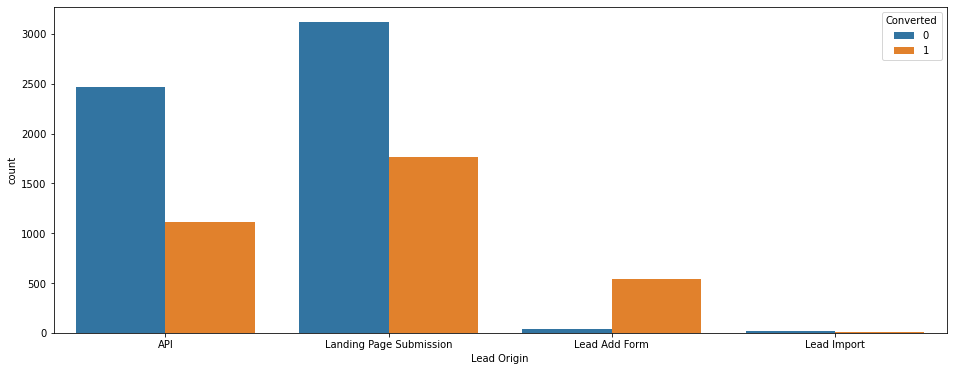

In [33]:
countplot("Lead Origin", 0)

**Inference :**
- Leads originating from API and Landing Page Submission have lower conversion
- Leads originating from Lead Add Form have higher conversion though the magnitude of customers is coming from them is small.

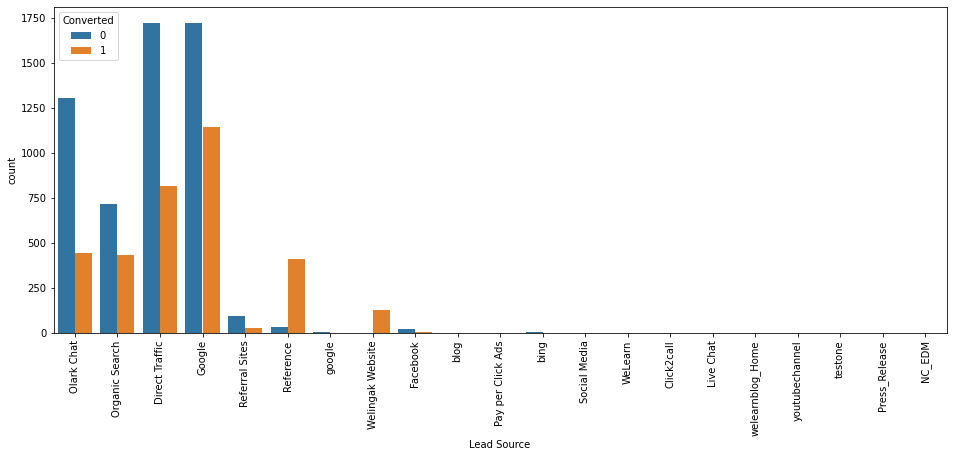

In [34]:
countplot("Lead Source", 90)

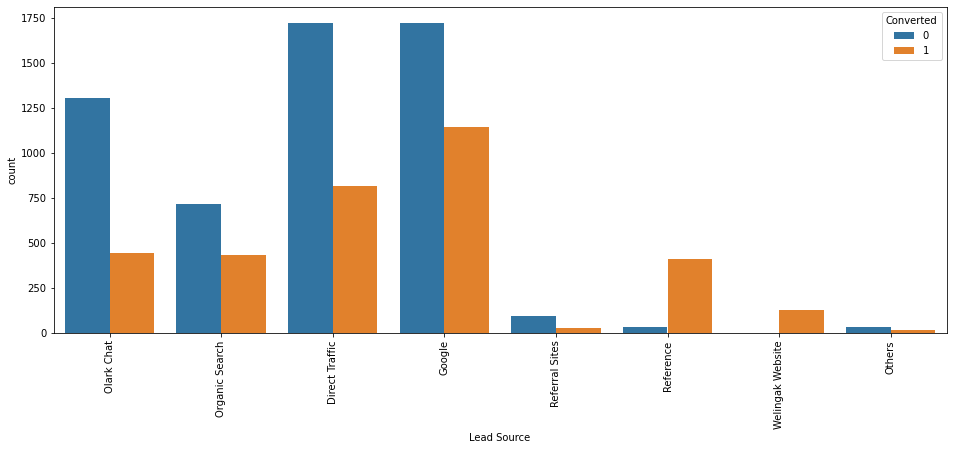

In [35]:
df["Lead Source"].replace(["google", "Facebook"] ,["Google", "Social Media"], inplace = True)

dummy1 = df["Lead Source"].value_counts()<100
vars_list = list(dummy1[dummy1 == True].index)
df["Lead Source"].replace(vars_list, "Others", inplace = True)

countplot("Lead Source", 90)

**Inference :**
- Grouping labels that are less in count to Other Category we have the above shown countplot
- Lead generation & Conversion Rate are high through Google, Direct Traffic.
- It can be seen that Leads that were sourced through references have higher conversion compared to other sources
- Our main focus should be on 4 source i.e. Olark Chat, Organic Search, Direct Traffic, Google

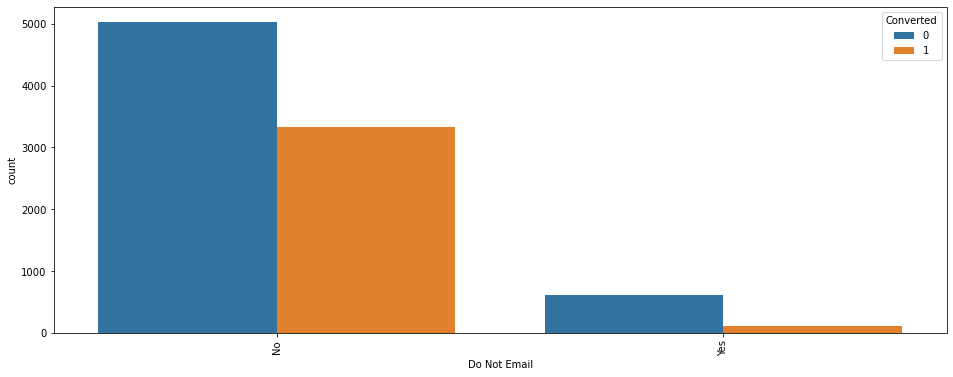

In [36]:
countplot("Do Not Email")

**Inference :**
- No special pattern seen in the `Do Not Email` variable

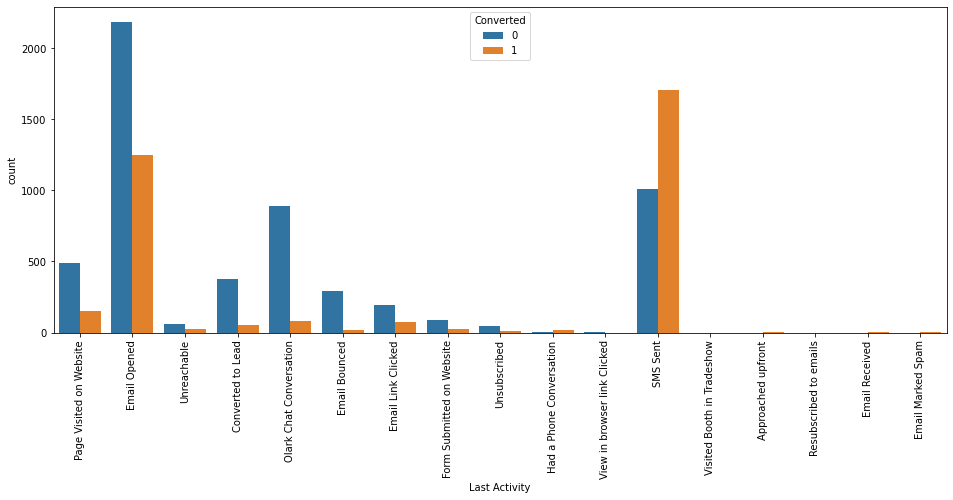

In [37]:
countplot("Last Activity")

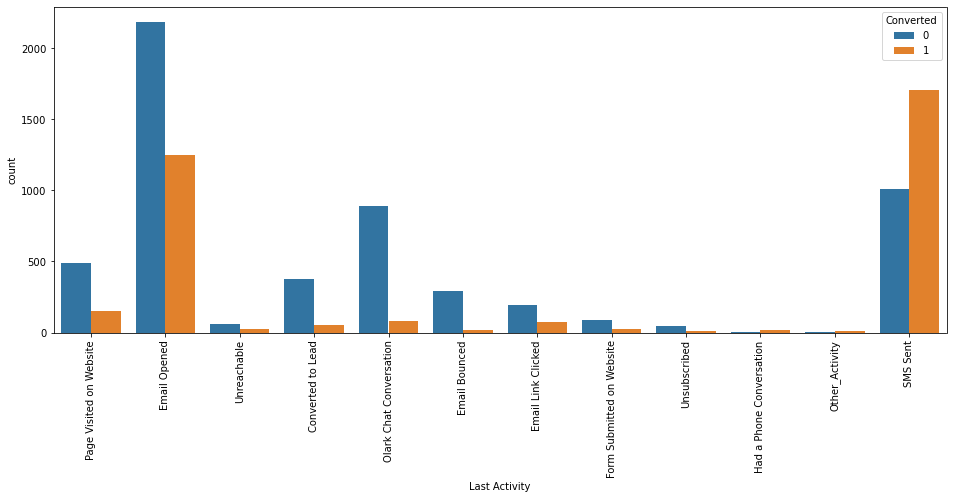

In [38]:
dummy2 = df["Last Activity"].value_counts()<25
vars_list = list(dummy2[dummy2 == True].index)
df["Last Activity"].replace(vars_list, "Other_Activity", inplace = True)

countplot("Last Activity", 90)

**Inference :**
- Customers whose Last Activity was `SMS Sent` had a better conversion 
- Customers whose Last Activity was `Email Opened` had a lower conversion

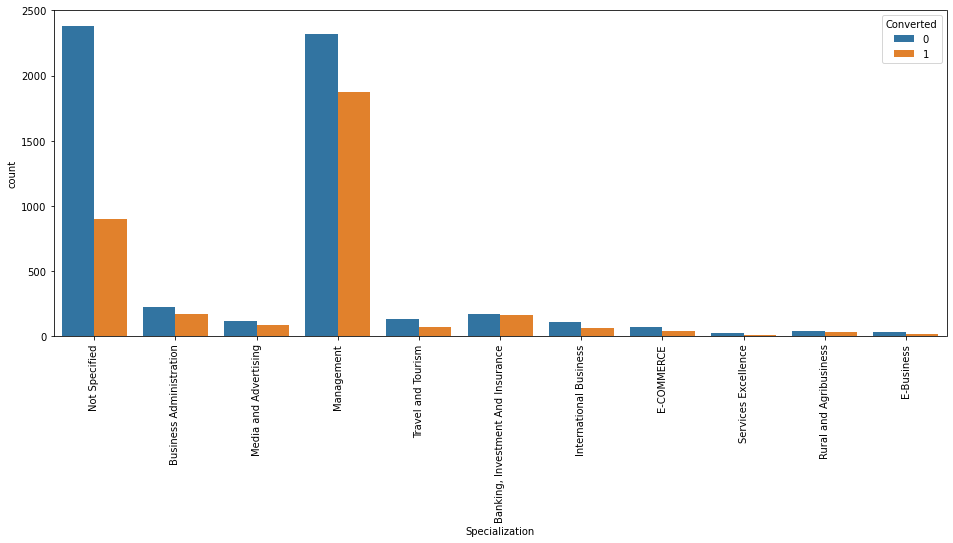

In [39]:
countplot("Specialization")

**Inference :**
- No specific pattern observed here

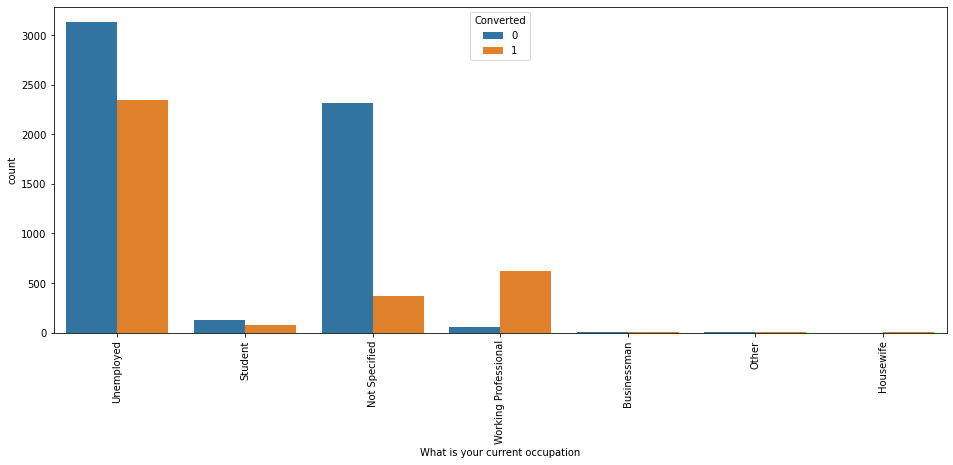

In [40]:
countplot("What is your current occupation")

**Inference :**
- Leads created from Working Professional has a better converstion

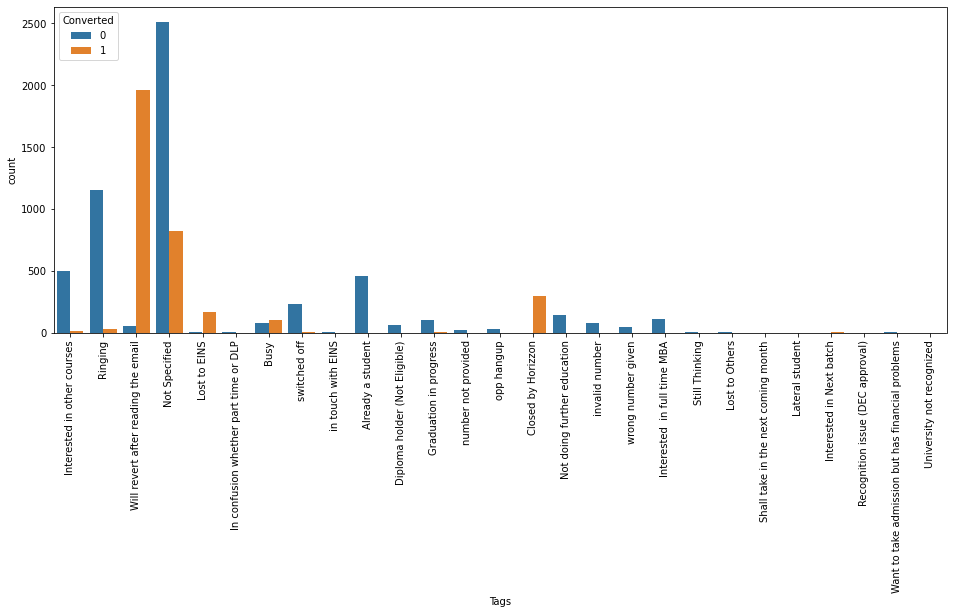

In [41]:
countplot("Tags", 90)

**Inference :**
- There are many labels in this feature with very low frequency.
- We'll categorize the low frequency labels into a single label

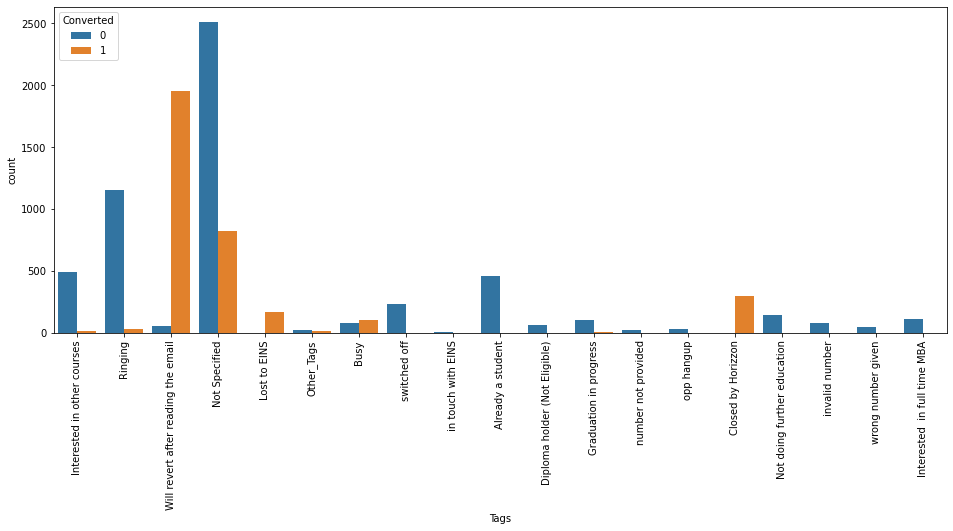

In [42]:
dummy3 = df["Tags"].value_counts()<12
vars_list = list(dummy3[dummy3 == True].index)
df["Tags"].replace(vars_list, "Other_Tags", inplace = True)

countplot("Tags", 90)

**Inference :**
- Tags with `Will revert after reading the email` has high conversion in terms of customer count

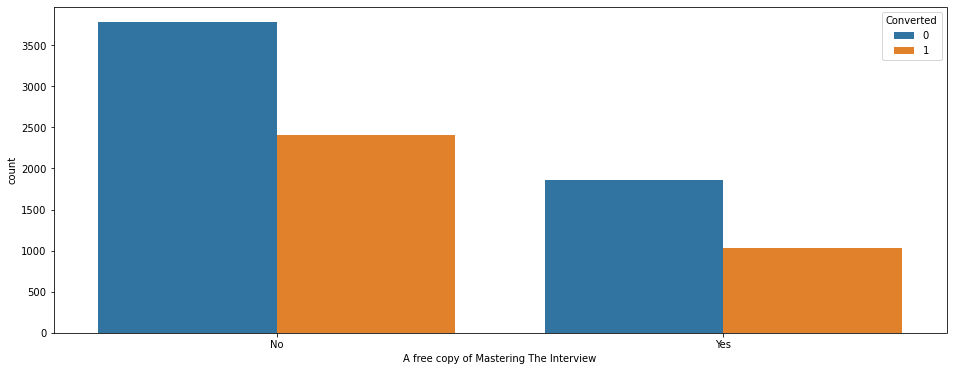

In [43]:
countplot("A free copy of Mastering The Interview", 0)

**Inference :**
- No specific pattern observed here

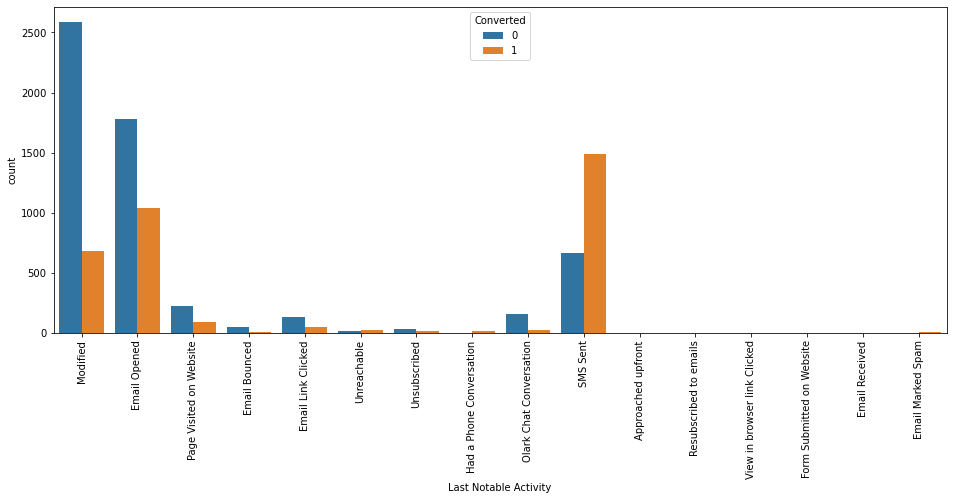

In [44]:
countplot("Last Notable Activity")

**Inference :**
- There are many labels in this feature with very low frequency.
- We'll categorize the low frequency labels into a single label

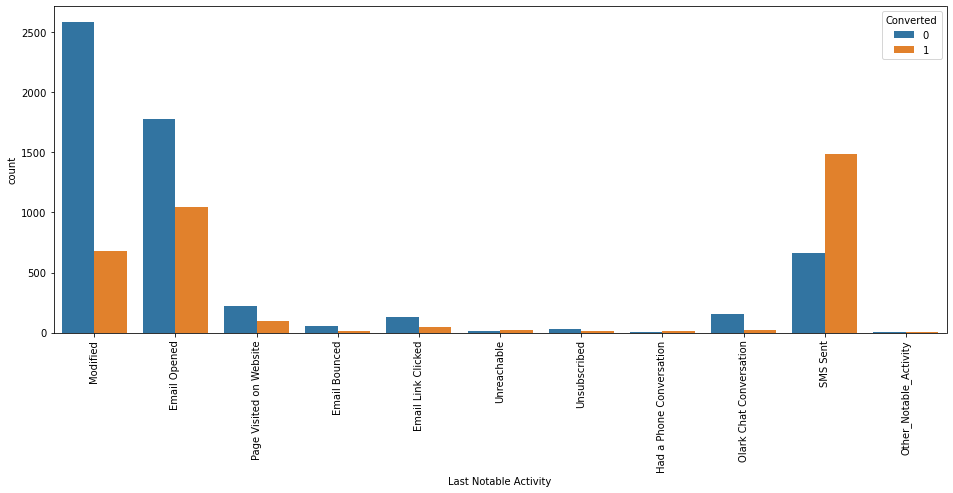

In [45]:
dummy4 = df["Last Notable Activity"].value_counts()<14
vars_list = list(dummy4[dummy4 == True].index)
df["Last Notable Activity"].replace(vars_list, "Other_Notable_Activity", inplace = True)

countplot("Last Notable Activity", 90)

**Inference :**
- Customers whose Last Notable Activity was `SMS Sent` had a better conversion 
- Customers whose Last Notable Activity was `Email Opened` and `Modified` had a lower conversion

In [46]:
# Dropping Prospect ID & Lead Number which is unique for each and every customer

df.drop(["Prospect ID", "Lead Number"], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9074 non-null   object 
 1   Lead Source                             9074 non-null   object 
 2   Do Not Email                            9074 non-null   object 
 3   Converted                               9074 non-null   int64  
 4   TotalVisits                             9074 non-null   float64
 5   Total Time Spent on Website             9074 non-null   int64  
 6   Page Views Per Visit                    9074 non-null   float64
 7   Last Activity                           9074 non-null   object 
 8   Specialization                          9074 non-null   object 
 9   What is your current occupation         9074 non-null   object 
 10  Tags                                    9074 non-null   obje

#### Correlation Matrix - Heatmap for Numeric Variables

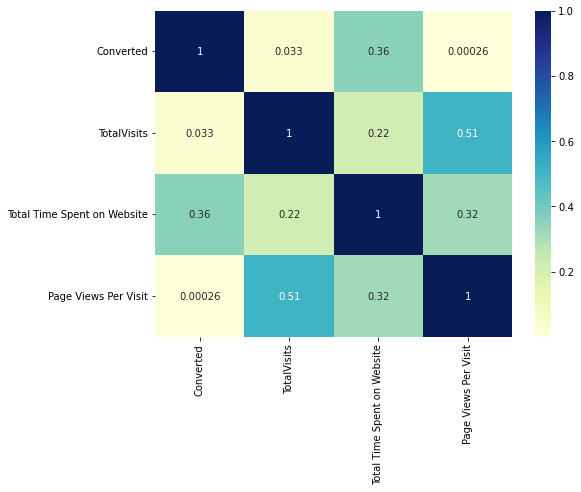

In [47]:
num_vars = df.select_dtypes(["int", "float"]).columns

plt.figure(figsize=(8,6))
sns.heatmap(df[num_vars].corr(), annot = True, cmap = 'YlGnBu')
plt.show()

**Inference :**
- **TotalVisits** & **Total Time Spent on Website** have a significant correlation with **Page views Per Visit.**

#### Univariate Analysis on Numeric Analysis

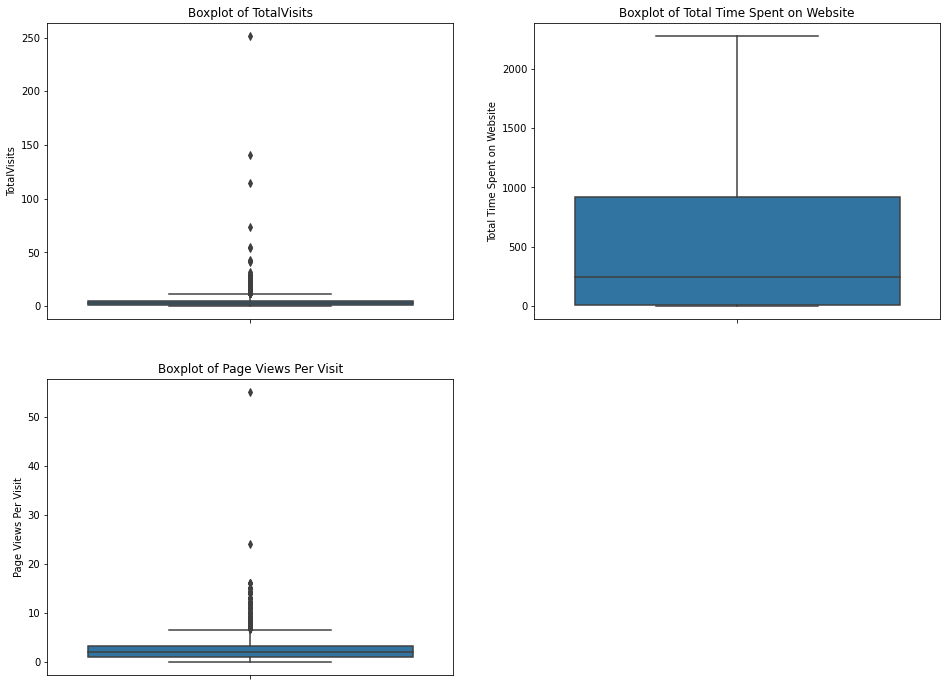

In [48]:
plt.figure(figsize = (16,12))

plt.subplot(2,2,1)
sns.boxplot(y = df["TotalVisits"])
plt.title("Boxplot of TotalVisits")

plt.subplot(2,2,2)
sns.boxplot(y = df["Total Time Spent on Website"])
plt.title("Boxplot of Total Time Spent on Website")

plt.subplot(2,2,3)
sns.boxplot(y = df["Page Views Per Visit"])
plt.title("Boxplot of Page Views Per Visit")
plt.show()

**Inference :**
- Clearly there are outliers seen in **TotalVisits** & **Page Views Per Visit**
- There is a wide range of dispersion seen in  **Total Time Spent on Website**

In [49]:
df["TotalVisits"].describe(percentiles = [0.01, 0.05, .10, .80, .90, .95, .99])

count    9074.000000
mean        3.456028
std         4.858802
min         0.000000
1%          0.000000
5%          0.000000
10%         0.000000
50%         3.000000
80%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [50]:
df["Page Views Per Visit"].describe(percentiles = [0.01, 0.05, .10, .80, .90, .95, .99])

count    9074.000000
mean        2.370151
std         2.160871
min         0.000000
1%          0.000000
5%          0.000000
10%         0.000000
50%         2.000000
80%         4.000000
90%         5.000000
95%         6.000000
99%         9.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

**Inference :**
- We'll remove top & bottom 1% of the values for both **TotalVisits** & **Page Views Per Visit**

In [51]:
Q3 = df["TotalVisits"].quantile(0.99)
df = df[(df["TotalVisits"] <= Q3)]
Q1 = df["TotalVisits"].quantile(0.01)
df = df[(df["TotalVisits"] >= Q1)]

In [52]:
Q3 = df["Page Views Per Visit"].quantile(0.99)
df = df[(df["Page Views Per Visit"] <= Q3)]
Q1 = df["Page Views Per Visit"].quantile(0.01)
df = df[(df["Page Views Per Visit"] >= Q1)]

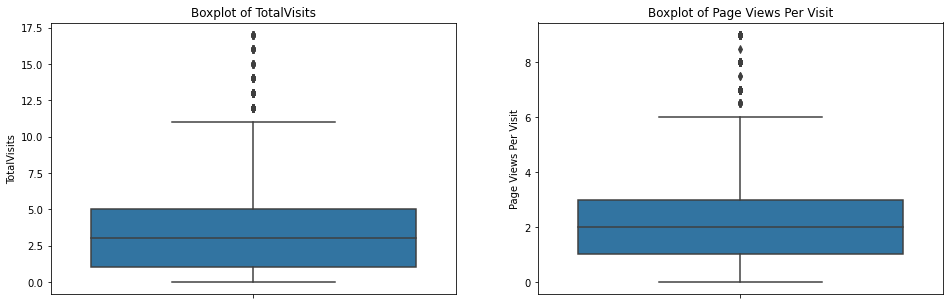

In [53]:
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
sns.boxplot(y = df["TotalVisits"])
plt.title("Boxplot of TotalVisits")

plt.subplot(1,2,2)
sns.boxplot(y = df["Page Views Per Visit"])
plt.title("Boxplot of Page Views Per Visit")

plt.show()

**Inference :**
- We can clearly see that both TotalVisits & Page Views Per Visit are lot more better now with outliers removed

#### Bivariate Analysis on Numeric Variables

#### Pair Plot of Continuous variables

<Figure size 432x288 with 0 Axes>

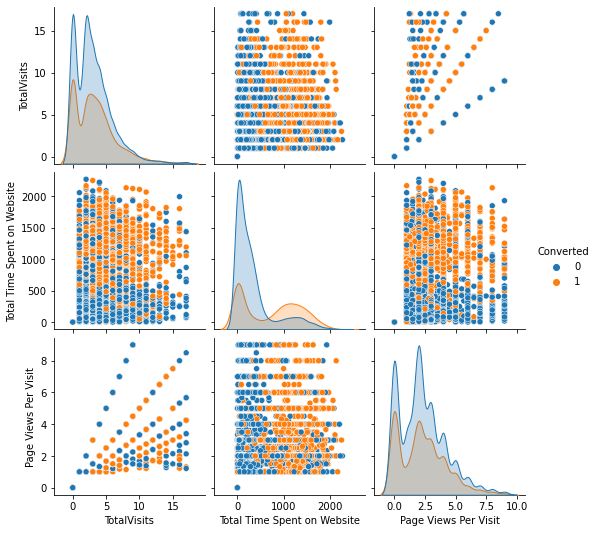

In [54]:
plt.figure()
sns.pairplot(data = df[["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit", "Converted"]], hue = "Converted")
plt.show()

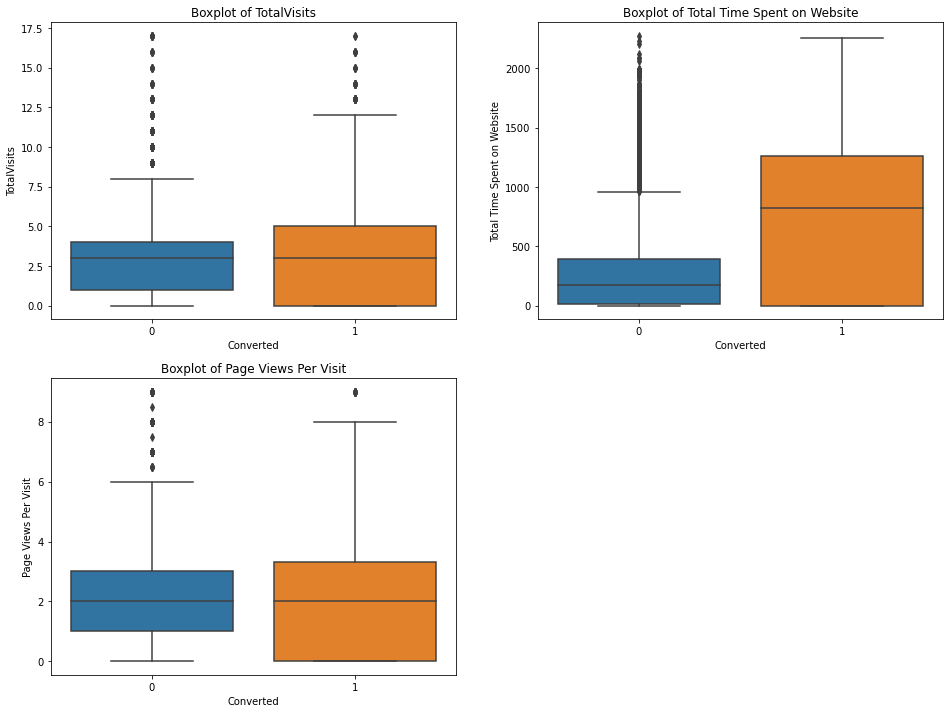

In [55]:
plt.figure(figsize = (16,12))

plt.subplot(2,2,1)
sns.boxplot(x = df["Converted"] ,y = df["TotalVisits"])
plt.title("Boxplot of TotalVisits")

plt.subplot(2,2,2)
sns.boxplot(x = df["Converted"] ,y = df["Total Time Spent on Website"])
plt.title("Boxplot of Total Time Spent on Website")

plt.subplot(2,2,3)
sns.boxplot(x = df["Converted"] ,y = df["Page Views Per Visit"])
plt.title("Boxplot of Page Views Per Visit")
plt.show()

**Inference :**
- The Total Time Spent on the website by the successfully converted customers is higher than the non-converters.
- There is a wide range of dispersion seen for successfully converted customers 

In [56]:
for i in df.select_dtypes("object").columns:
    print(df[i].value_counts())
    print()

Landing Page Submission    4768
API                        3546
Lead Add Form               580
Lead Import                  30
Name: Lead Origin, dtype: int64

Google              2841
Direct Traffic      2499
Olark Chat          1751
Organic Search      1092
Reference            442
Welingak Website     129
Referral Sites       117
Others                53
Name: Lead Source, dtype: int64

No     8235
Yes     689
Name: Do Not Email, dtype: int64

Email Opened                 3385
SMS Sent                     2678
Olark Chat Conversation       966
Page Visited on Website       594
Converted to Lead             428
Email Bounced                 310
Email Link Clicked            264
Form Submitted on Website     114
Unreachable                    88
Unsubscribed                   58
Had a Phone Conversation       24
Other_Activity                 15
Name: Last Activity, dtype: int64

Management                           4119
Not Specified                        3262
Business Administrati

**Inference :**
- Except `Do Not Email` & `A free copy of Mastering The Interview` all others are categorical variables with multi-classes
- SO we'll **Label Encode binary categorical variables** and **One Hot Encode multi-class categorical variables**

#### Label Encoding of Binary Categorical Variables

In [57]:
binary_cat_vars = ["Do Not Email" , "A free copy of Mastering The Interview"]

def binary_map(x):
    return x.map({"Yes" : 1, "No" : 0})
    

df[binary_cat_vars] = df[binary_cat_vars].apply(binary_map)

#### One Hot Encoding of Multi-Class Categorical Variables

In [58]:
dummy = pd.get_dummies(data = df[df.select_dtypes("object").columns])
dummy.drop(["Lead Origin_API", "Lead Source_Others", "Last Activity_Other_Activity",
            "What is your current occupation_Not Specified", "Specialization_Not Specified",
            "Last Notable Activity_Other_Notable_Activity", "Tags_Other_Tags"], axis = 1, inplace = True)
df = pd.concat([df,dummy], axis = 1)
df.drop(df.select_dtypes("object").columns, axis = 1, inplace = True)
df.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,...,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed
0,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,2.0,1532,2.0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1.0,305,1.0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,1,2.0,1428,1.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Heatmap - Correlation matrix

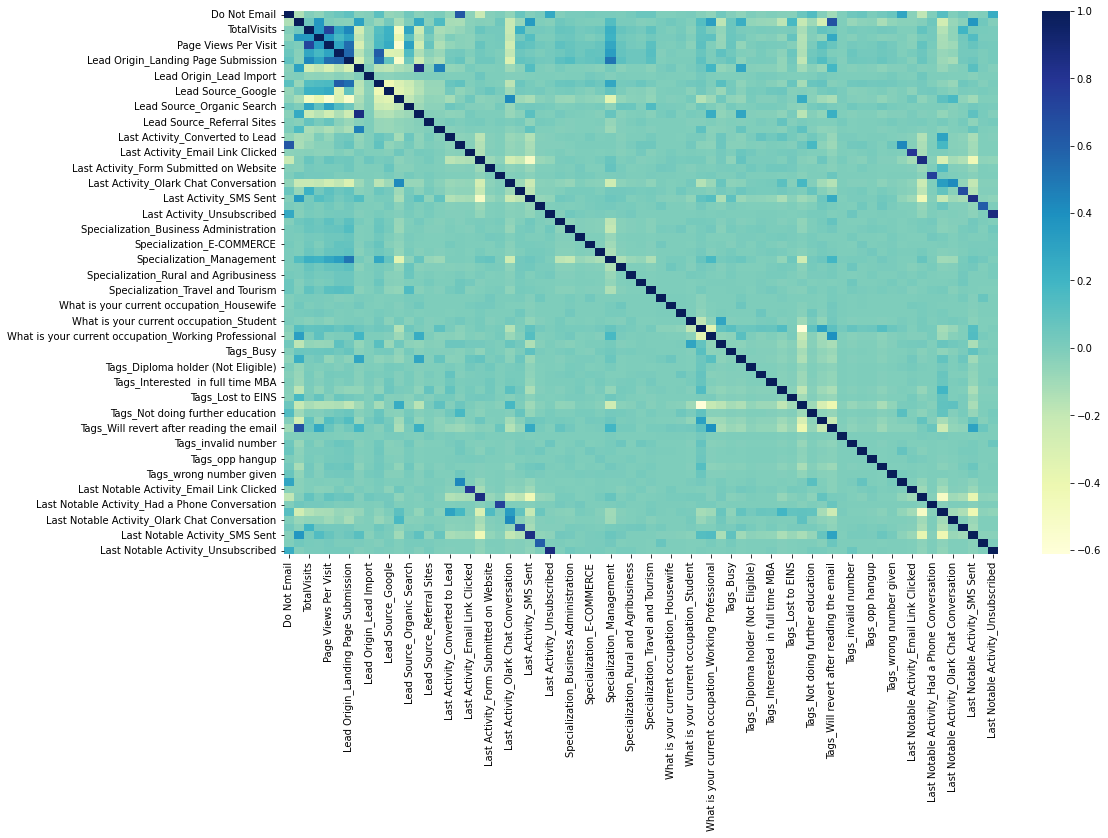

In [59]:
plt.figure(figsize = (16,10))
sns.heatmap(df.corr(), cmap = "YlGnBu")
plt.show()

In [60]:
# Checking the target variable

conversion = round(df.Converted.mean()*100,2)
conversion

37.75

**Inference :**
- The conversion ratio is 37.75 %

### Splitting into Train and Test Splits

In [61]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=100)
print(df_train.shape)
print(df_test.shape)

(6693, 71)
(2231, 71)


#### Scaling of Numerical Variables

In [62]:
num_vars = ["TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"]

scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [63]:
y_train = df_train.pop("Converted")
X_train = df_train

## Model Building

In [64]:
log_reg = LogisticRegression()
rfe = RFE(log_reg, 20)
rfe = rfe.fit(X_train, y_train)

In [65]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', False, 7),
 ('TotalVisits', False, 15),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('A free copy of Mastering The Interview', False, 48),
 ('Lead Origin_Landing Page Submission', False, 24),
 ('Lead Origin_Lead Add Form', False, 9),
 ('Lead Origin_Lead Import', False, 31),
 ('Lead Source_Direct Traffic', False, 36),
 ('Lead Source_Google', False, 47),
 ('Lead Source_Olark Chat', False, 14),
 ('Lead Source_Organic Search', False, 46),
 ('Lead Source_Reference', False, 51),
 ('Lead Source_Referral Sites', False, 29),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Converted to Lead', False, 20),
 ('Last Activity_Email Bounced', False, 21),
 ('Last Activity_Email Link Clicked', False, 49),
 ('Last Activity_Email Opened', False, 40),
 ('Last Activity_Form Submitted on Website', False, 50),
 ('Last Activity_Had a Phone Conversation', False, 5),
 ('Last Activity_Olark Chat Conversation', False, 18),
 ('Last Activity_Page Vis

In [66]:
cols = X_train.columns[rfe.support_]
cols

Index(['Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Tags_Already a student', 'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Lost to EINS', 'Tags_Not Specified', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_number not provided', 'Tags_switched off',
       'Tags_wrong number given', 'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

#### Model 1 - Using Statsmodels & Important Features derived from RFE

In [67]:
X_train_rfe = X_train[cols]
X_train_sm = sm.add_constant(X_train_rfe)
log_reg_1 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial()).fit()
log_reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6693
Model:                            GLM   Df Residuals:                     6672
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1166.1
Date:                Tue, 08 Feb 2022   Deviance:                       2332.2
Time:                        12:59:50   Pearson chi2:                 9.39e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -5.6750      0.288    -19.713      0.000      -6.239      -5.111
Total Time Spent on Website                              4.0479      0.245     16.551      0.000       3.569       4.527
Page Views Per Visit                                    -1.8667      0.309     -6.040      0.000      -2.473      -1.261
Lead Source_Welingak Website                             2.7947      0.748      3.736      0.000       1.329       4.261
Last Activity_SMS Sent                                   2.1396      0.125     17.076      0.000       1.894       2.385
What is your current occupation_Student                  1.8839      0.481      3.913      0.000       0.940       2.827
What is your current occupation_Unemployed               2.3815      0.148     16.080      0.000       2.091       2.672
What is your current occupation_Working Professional     2.6283      0.366      7.184      0.000       1.911       3.345
Tags_Already a student                                  -1.5464      0.628     -2.464      0.014      -2.777      -0.316
Tags_Busy                                                2.2560      0.301      7.487      0.000       1.665       2.847
Tags_Closed by Horizzon                                  8.8735      0.763     11.625      0.000       7.377      10.370
Tags_Lost to EINS                                        8.1510      0.592     13.773      0.000       6.991       9.311
Tags_Not Specified                                       3.2362      0.242     13.400      0.000       2.763       3.710
Tags_Ringing                                            -2.0466      0.316     -6.484      0.000      -2.665      -1.428
Tags_Will revert after reading the email                 6.1712      0.271     22.746      0.000       5.639       6.703
Tags_invalid number                                     -2.6038      1.176     -2.215      0.027      -4.908      -0.299
Tags_number not provided                               -23.5538   2.67e+04     -0.001      0.999   -5.25e+04    5.24e+04
Tags_switched off                                       -2.7456      0.761     -3.606      0.000      -4.238      -1.253
Tags_wrong number given                                -22.7507   1.86e+04     -0.001      0.999   -3.64e+04    3.64e+04
Last Notable Activity_Modified                          -1.6411      0.129    -12.732      0.000      -1.894      -1.388
Last Notable Activity_Olark Chat Conversation           -1.8757      0.471     -3.984      0.000      -2.798      -0.953
========================================================================================================================
"""

#### Checking of VIF

In [68]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,What is your current occupation_Unemployed,4.23
13,Tags_Will revert after reading the email,2.85
1,Page Views Per Visit,2.77
0,Total Time Spent on Website,2.27
12,Tags_Ringing,1.88
11,Tags_Not Specified,1.80
6,What is your current occupation_Working Profes...,1.71
3,Last Activity_SMS Sent,1.70
18,Last Notable Activity_Modified,1.59
7,Tags_Already a student,1.42


#### Model 2 : Removing variable `Tags_number not provided` due to high p-value

In [69]:
X_train_rfe = X_train_rfe.drop("Tags_number not provided", axis = 1)
X_train_sm = sm.add_constant(X_train_rfe)
log_reg_2 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_reg_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6693
Model:                            GLM   Df Residuals:                     6673
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1170.7
Date:                Tue, 08 Feb 2022   Deviance:                       2341.3
Time:                        12:59:50   Pearson chi2:                 9.24e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -5.7976      0.289    -20.031      0.000      -6.365      -5.230
Total Time Spent on Website                              4.0217      0.244     16.496      0.000       3.544       4.500
Page Views Per Visit                                    -1.8387      0.309     -5.960      0.000      -2.443      -1.234
Lead Source_Welingak Website                             2.7971      0.747      3.742      0.000       1.332       4.262
Last Activity_SMS Sent                                   2.1128      0.124     16.978      0.000       1.869       2.357
What is your current occupation_Student                  1.8918      0.482      3.925      0.000       0.947       2.837
What is your current occupation_Unemployed               2.3753      0.148     16.095      0.000       2.086       2.665
What is your current occupation_Working Professional     2.6388      0.367      7.183      0.000       1.919       3.359
Tags_Already a student                                  -1.4168      0.628     -2.256      0.024      -2.648      -0.186
Tags_Busy                                                2.3919      0.301      7.938      0.000       1.801       2.982
Tags_Closed by Horizzon                                  8.9800      0.764     11.751      0.000       7.482      10.478
Tags_Lost to EINS                                        8.2615      0.593     13.940      0.000       7.100       9.423
Tags_Not Specified                                       3.3650      0.243     13.858      0.000       2.889       3.841
Tags_Ringing                                            -1.8959      0.315     -6.026      0.000      -2.513      -1.279
Tags_Will revert after reading the email                 6.2869      0.273     23.003      0.000       5.751       6.823
Tags_invalid number                                     -2.4463      1.172     -2.087      0.037      -4.743      -0.149
Tags_switched off                                       -2.5950      0.761     -3.412      0.001      -4.086      -1.104
Tags_wrong number given                                -21.6015   1.13e+04     -0.002      0.998   -2.21e+04    2.21e+04
Last Notable Activity_Modified                          -1.6220      0.129    -12.608      0.000      -1.874      -1.370
Last Notable Activity_Olark Chat Conversation           -1.8713      0.470     -3.981      0.000      -2.793      -0.950
========================================================================================================================
"""

#### Checking of VIF

In [70]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,What is your current occupation_Unemployed,4.19
13,Tags_Will revert after reading the email,2.82
1,Page Views Per Visit,2.76
0,Total Time Spent on Website,2.27
12,Tags_Ringing,1.87
11,Tags_Not Specified,1.79
3,Last Activity_SMS Sent,1.70
6,What is your current occupation_Working Profes...,1.70
17,Last Notable Activity_Modified,1.59
7,Tags_Already a student,1.41


#### Model 3 : Removing variable `Tags_wrong number given` due to high p-value

In [71]:
X_train_rfe = X_train_rfe.drop("Tags_wrong number given", axis = 1)
X_train_sm = sm.add_constant(X_train_rfe)
log_reg_3 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_reg_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6693
Model:                            GLM   Df Residuals:                     6674
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1175.5
Date:                Tue, 08 Feb 2022   Deviance:                       2351.1
Time:                        12:59:50   Pearson chi2:                 9.16e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -5.9573      0.290    -20.537      0.000      -6.526      -5.389
Total Time Spent on Website                              4.0250      0.243     16.548      0.000       3.548       4.502
Page Views Per Visit                                    -1.8476      0.308     -6.005      0.000      -2.451      -1.245
Lead Source_Welingak Website                             2.7981      0.747      3.746      0.000       1.334       4.262
Last Activity_SMS Sent                                   2.0877      0.124     16.879      0.000       1.845       2.330
What is your current occupation_Student                  1.9016      0.483      3.934      0.000       0.954       2.849
What is your current occupation_Unemployed               2.3694      0.147     16.100      0.000       2.081       2.658
What is your current occupation_Working Professional     2.6514      0.370      7.175      0.000       1.927       3.376
Tags_Already a student                                  -1.2546      0.628     -1.997      0.046      -2.486      -0.024
Tags_Busy                                                2.5684      0.299      8.577      0.000       1.981       3.155
Tags_Closed by Horizzon                                  9.1275      0.765     11.935      0.000       7.629      10.626
Tags_Lost to EINS                                        8.4099      0.593     14.177      0.000       7.247       9.573
Tags_Not Specified                                       3.5321      0.242     14.573      0.000       3.057       4.007
Tags_Ringing                                            -1.7098      0.312     -5.485      0.000      -2.321      -1.099
Tags_Will revert after reading the email                 6.4447      0.274     23.533      0.000       5.908       6.981
Tags_invalid number                                     -2.2585      1.171     -1.929      0.054      -4.553       0.036
Tags_switched off                                       -2.4085      0.759     -3.172      0.002      -3.897      -0.920
Last Notable Activity_Modified                          -1.6040      0.129    -12.481      0.000      -1.856      -1.352
Last Notable Activity_Olark Chat Conversation           -1.8704      0.470     -3.980      0.000      -2.791      -0.949
========================================================================================================================
"""

#### Checking of VIF

In [72]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,What is your current occupation_Unemployed,4.12
13,Tags_Will revert after reading the email,2.77
1,Page Views Per Visit,2.75
0,Total Time Spent on Website,2.27
12,Tags_Ringing,1.84
11,Tags_Not Specified,1.78
3,Last Activity_SMS Sent,1.70
6,What is your current occupation_Working Profes...,1.70
16,Last Notable Activity_Modified,1.59
7,Tags_Already a student,1.40


#### Model 4 : Removing variable `Tags_invalid number` due to high p-value

In [73]:
X_train_rfe = X_train_rfe.drop("Tags_invalid number", axis = 1)
X_train_sm = sm.add_constant(X_train_rfe)
log_reg_4 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_reg_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6693
Model:                            GLM   Df Residuals:                     6675
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1178.5
Date:                Tue, 08 Feb 2022   Deviance:                       2357.0
Time:                        12:59:51   Pearson chi2:                 9.11e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -6.0957      0.289    -21.103      0.000      -6.662      -5.530
Total Time Spent on Website                              4.0257      0.243     16.562      0.000       3.549       4.502
Page Views Per Visit                                    -1.8473      0.307     -6.027      0.000      -2.448      -1.246
Lead Source_Welingak Website                             2.7998      0.746      3.751      0.000       1.337       4.263
Last Activity_SMS Sent                                   2.0689      0.123     16.793      0.000       1.827       2.310
What is your current occupation_Student                  1.9101      0.485      3.942      0.000       0.960       2.860
What is your current occupation_Unemployed               2.3654      0.147     16.105      0.000       2.077       2.653
What is your current occupation_Working Professional     2.6618      0.371      7.168      0.000       1.934       3.390
Tags_Already a student                                  -1.1156      0.628     -1.777      0.076      -2.346       0.115
Tags_Busy                                                2.7172      0.297      9.155      0.000       2.135       3.299
Tags_Closed by Horizzon                                  9.2560      0.765     12.104      0.000       7.757      10.755
Tags_Lost to EINS                                        8.5394      0.593     14.400      0.000       7.377       9.702
Tags_Not Specified                                       3.6747      0.240     15.288      0.000       3.204       4.146
Tags_Ringing                                            -1.5536      0.308     -5.036      0.000      -2.158      -0.949
Tags_Will revert after reading the email                 6.5800      0.273     24.111      0.000       6.045       7.115
Tags_switched off                                       -2.2520      0.758     -2.971      0.003      -3.738      -0.766
Last Notable Activity_Modified                          -1.5913      0.128    -12.388      0.000      -1.843      -1.340
Last Notable Activity_Olark Chat Conversation           -1.8705      0.470     -3.982      0.000      -2.791      -0.950
========================================================================================================================
"""

#### Checking of VIF

In [74]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,What is your current occupation_Unemployed,4.00
1,Page Views Per Visit,2.74
13,Tags_Will revert after reading the email,2.71
0,Total Time Spent on Website,2.27
12,Tags_Ringing,1.79
11,Tags_Not Specified,1.77
3,Last Activity_SMS Sent,1.69
6,What is your current occupation_Working Profes...,1.69
15,Last Notable Activity_Modified,1.59
7,Tags_Already a student,1.39


#### Model 5 : Removing variable `Tags_Already a student` due to high p-value

In [75]:
X_train_rfe = X_train_rfe.drop("Tags_Already a student", axis = 1)
X_train_sm = sm.add_constant(X_train_rfe)
log_reg_5 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_reg_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6693
Model:                            GLM   Df Residuals:                     6676
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1180.5
Date:                Tue, 08 Feb 2022   Deviance:                       2361.1
Time:                        12:59:51   Pearson chi2:                 9.17e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -6.2961      0.277    -22.757      0.000      -6.838      -5.754
Total Time Spent on Website                              4.0093      0.242     16.551      0.000       3.535       4.484
Page Views Per Visit                                    -1.8229      0.307     -5.944      0.000      -2.424      -1.222
Lead Source_Welingak Website                             2.7967      0.747      3.746      0.000       1.333       4.260
Last Activity_SMS Sent                                   2.0952      0.123     17.012      0.000       1.854       2.337
What is your current occupation_Student                  1.8351      0.467      3.927      0.000       0.919       2.751
What is your current occupation_Unemployed               2.3735      0.147     16.140      0.000       2.085       2.662
What is your current occupation_Working Professional     2.6678      0.372      7.170      0.000       1.939       3.397
Tags_Busy                                                2.8916      0.289     10.005      0.000       2.325       3.458
Tags_Closed by Horizzon                                  9.4435      0.761     12.407      0.000       7.952      10.935
Tags_Lost to EINS                                        8.7308      0.588     14.849      0.000       7.578       9.883
Tags_Not Specified                                       3.8604      0.228     16.908      0.000       3.413       4.308
Tags_Ringing                                            -1.3839      0.301     -4.594      0.000      -1.974      -0.793
Tags_Will revert after reading the email                 6.7674      0.262     25.804      0.000       6.253       7.281
Tags_switched off                                       -2.0832      0.755     -2.759      0.006      -3.563      -0.603
Last Notable Activity_Modified                          -1.5847      0.128    -12.336      0.000      -1.836      -1.333
Last Notable Activity_Olark Chat Conversation           -1.8669      0.469     -3.982      0.000      -2.786      -0.948
========================================================================================================================
"""

#### Checking of VIF

In [76]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,What is your current occupation_Unemployed,3.51
1,Page Views Per Visit,2.74
12,Tags_Will revert after reading the email,2.49
0,Total Time Spent on Website,2.27
10,Tags_Not Specified,1.73
3,Last Activity_SMS Sent,1.69
11,Tags_Ringing,1.67
6,What is your current occupation_Working Profes...,1.62
14,Last Notable Activity_Modified,1.58
8,Tags_Closed by Horizzon,1.18


**Inference :**
- All the feautures seems to be within acceptible limits in terms of both p-values and VIF.
- So we'll go ahead with log_reg_5 model.

## Model Evaluation

### Sensitivity-Specificity View

In [77]:
#Prediction on the Training Data

y_train_pred = log_reg_5.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:5]

array([0.00499734, 0.10662149, 0.0030502 , 0.03191774, 0.02151318])

In [78]:
# Setting threshold probability cut-off vaue as 0.5

y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_prob,Predicted
0,0,0.004997,0
1,0,0.106621,0
2,0,0.003050,0
3,0,0.031918,0
4,0,0.021513,0


In [79]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[4001  149]
 [ 291 2252]]


In [80]:
accuracy = accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted)

In [81]:
# Evaluating other metrics

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [82]:
Sensitivity = TP/float(TP+FN)
Specificity = TN/float(TN+FP)
print("Train Accuracy :", round(accuracy,4))
print("Train Sensitivity :", round(Sensitivity,4))
print("Train Specificity :", round(Specificity,4))

Train Accuracy : 0.9343
Train Sensitivity : 0.8856
Train Specificity : 0.9641


#### Plotting the ROC-AUC Curve

In [83]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [84]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_prob, 
                                         drop_intermediate = False )

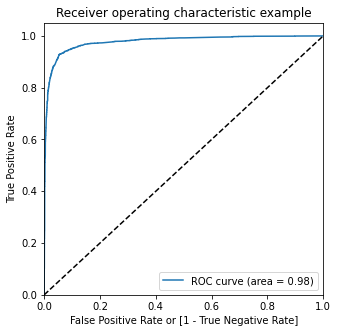

In [85]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

#### Finding Optimal cut-off point

In [86]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.004997,0,1,0,0,0,0,0,0,0,0,0
1,0,0.106621,0,1,1,0,0,0,0,0,0,0,0
2,0,0.003050,0,1,0,0,0,0,0,0,0,0,0
3,0,0.031918,0,1,0,0,0,0,0,0,0,0,0
4,0,0.021513,0,1,0,0,0,0,0,0,0,0,0


In [87]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.379949  1.000000  0.000000
0.1   0.1  0.882564  0.971687  0.827952
0.2   0.2  0.919169  0.952025  0.899036
0.3   0.3  0.931421  0.939835  0.926265
0.4   0.4  0.939041  0.928824  0.945301
0.5   0.5  0.934260  0.885568  0.964096
0.6   0.6  0.932168  0.869446  0.970602
0.7   0.7  0.927088  0.847818  0.975663
0.8   0.8  0.918422  0.813213  0.982892
0.9   0.9  0.895413  0.742037  0.989398


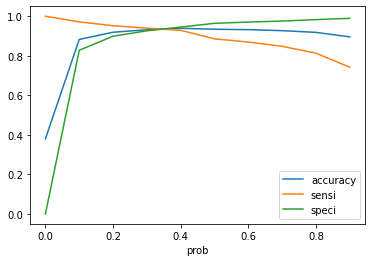

In [88]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Inference :**
- The optimal cut-off value is found to be 0.38

In [89]:
y_train_pred_final['final_Predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.38 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,0,0.004997,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.106621,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.003050,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.031918,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.021513,0,1,0,0,0,0,0,0,0,0,0,0


In [90]:
confusion1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)
confusion1

array([[3908,  242],
       [ 177, 2366]], dtype=int64)

In [91]:
# Evaluating other metrics

TP = confusion1[1,1] # true positive 
TN = confusion1[0,0] # true negatives
FP = confusion1[0,1] # false positives
FN = confusion1[1,0] # false negatives

In [92]:
Accuracy = metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

In [93]:
Sensitivity = TP/float(TP+FN)
Specificity = TN/float(TN+FP)
print("Train Accuracy :", round(Accuracy,4))
print("Train Sensitivity :", round(Sensitivity,4))
print("Train Specificity :", round(Specificity,4))

Train Accuracy : 0.9374
Train Sensitivity : 0.9304
Train Specificity : 0.9417


## Predicting it on the Test Dataset

In [94]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [95]:
df_test[num_vars].describe()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,2231.000000,2231.000000,2231.000000
mean,0.187307,0.208641,0.256132
std,0.175418,0.236193,0.213754
min,0.000000,0.000000,0.000000
25%,0.058824,0.003521,0.111111
50%,0.176471,0.106954,0.222222
75%,0.294118,0.402729,0.333333
max,1.000000,0.991637,1.000000


In [96]:
y_test = df_test.pop("Converted")
X_test = df_test

In [97]:
X_test_rfe = X_test[X_train_rfe.columns]
X_test_sm = sm.add_constant(X_test_rfe)
y_test_pred = log_reg_5.predict(X_test_sm)

### Making Predictions on the Test Set

In [98]:
y_test_pred_final = pd.DataFrame({'Converted':y_test.values, 'Converted_prob':y_test_pred, "Lead Score" : round(y_test_pred*100)})
y_test_pred_final['Predicted'] = y_test_pred_final.Converted_prob.map(lambda x: 1 if x > 0.39 else 0)
y_test_pred_final.head()

,Converted,Converted_prob,Lead Score,Predicted
7625,0,0.187366,19.0,0
5207,1,0.973398,97.0,1
2390,1,0.992895,99.0,1
4362,0,0.038903,4.0,0
1023,0,0.012420,1.0,0


In [99]:
confusion2 = metrics.confusion_matrix(y_test_pred_final['Converted'], y_test_pred_final.Predicted )
confusion2

array([[1322,   83],
       [  59,  767]], dtype=int64)

In [100]:
# Evaluating other metrics

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [101]:
test_accuracy = accuracy_score(y_test_pred_final.Converted, y_test_pred_final.Predicted)

In [102]:
test_Sensitivity = TP/float(TP+FN)
test_Specificity = TN/float(TN+FP)
print("Test Accuracy :", round(test_accuracy, 4))
print("Test Sensitivity :", round(test_Sensitivity,4))
print("Test Specificity :", round(test_Specificity,4))

Test Accuracy : 0.9364
Test Sensitivity : 0.9286
Test Specificity : 0.9409


### Precision-Recall View

In [103]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[4001  149]
 [ 291 2252]]


In [104]:
##### Precision
## Precision = TP / TP + FP

precision = confusion[1,1]/(confusion[0,1]+confusion[1,1])
print("Precision :", precision)

Precision : 0.9379425239483549


In [105]:
##### Recall
## Recall = TP / TP + FN

recall = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print("Recall :", recall)

Recall : 0.885568226504129


#### Precision Recall Curve

In [106]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

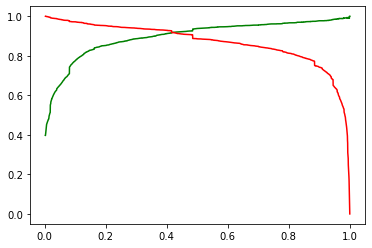

In [107]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [108]:
y_train_pred_final['final_Predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.42 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,0,0.004997,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.106621,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.003050,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.031918,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.021513,0,1,0,0,0,0,0,0,0,0,0,0


In [109]:
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.9376961004034066

In [110]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion2

array([[3944,  206],
       [ 211, 2332]], dtype=int64)

In [111]:
# Let's evaluate the other metrics as well

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [112]:
accuracy = accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)
precision = TP/float(TP+FP)
recall = TP/float(TP+FN)
print("Train Accuracy :", round(accuracy, 4))
print("Train Precision :", round(precision,4))
print("Train Recall :", round(recall,4))

Train Accuracy : 0.9377
Train Precision : 0.9188
Train Recall : 0.917


### Making Predictions on the Test Set

In [113]:
y_test_pred = log_reg_5.predict(X_test_sm)

In [114]:
y_test.index

Int64Index([7625, 5207, 2390, 4362, 1023, 8226, 3079,  530, 7873, 5146,
            ...
            3144, 6559, 8602, 6923, 1122, 5560, 4040, 7451, 2094, 2545],
           dtype='int64', length=2231)

In [115]:
y_test_pred_final = pd.DataFrame({"Converted" : y_test, "Pred_Prob" : y_test_pred, "Lead Score" : round(y_test_pred*100)})
y_test_pred_final["final_Predicted"] = y_test_pred_final.Pred_Prob.map(lambda x: 1 if x > 0.42 else 0)
y_test_pred_final.head()

,Converted,Pred_Prob,Lead Score,final_Predicted
7625,0,0.187366,19.0,0
5207,1,0.973398,97.0,1
2390,1,0.992895,99.0,1
4362,0,0.038903,4.0,0
1023,0,0.012420,1.0,0


In [116]:
confusion_test = confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.final_Predicted)
print(confusion_test)

[[1334   71]
 [  72  754]]


In [117]:
# Let's evaluate the other metrics as well

TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

In [118]:
accuracy = accuracy_score(y_test_pred_final.Converted, y_test_pred_final.final_Predicted)
precision = TP/float(TP+FP)
recall = TP/float(TP+FN)
print("Test Accuracy :", round(accuracy,4))
print("Test Precision :", round(precision,4))
print("Test Recall :", round(recall,4))

Test Accuracy : 0.9359
Test Precision : 0.9139
Test Recall : 0.9128


## Conclusion - Summary

#### <u>Train Data</u>              
   - Accuracy:      94% <br>
<br>**Sensitivity-Specificity Approach**
   - Sensitivity:   93%
   - Specificity:   94% <br>
<br>**Precision-Recall Approach**
   - Precision:     92%
   - Recall:        92%

#### <u>Test Data</u>              
   - Accuracy:      94% <br>
<br>**Sensitivity-Specificity Approach**
   - Sensitivity:   93%
   - Specificity:   94% <br>
<br>**Precision-Recall Approach**
   - Precision:     91%
   - Recall:        91%

### Inference on Feature Importance of the model

In [119]:
feature = pd.DataFrame(log_reg_5.params)
feature.reset_index(level=0, inplace=True)
feature.columns = ["Features", "Co-efficients"]
feature = feature[1:]
feature["Co-efficients"] = round(feature["Co-efficients"],2)
feature.sort_values("Co-efficients", ascending = True, inplace=True)

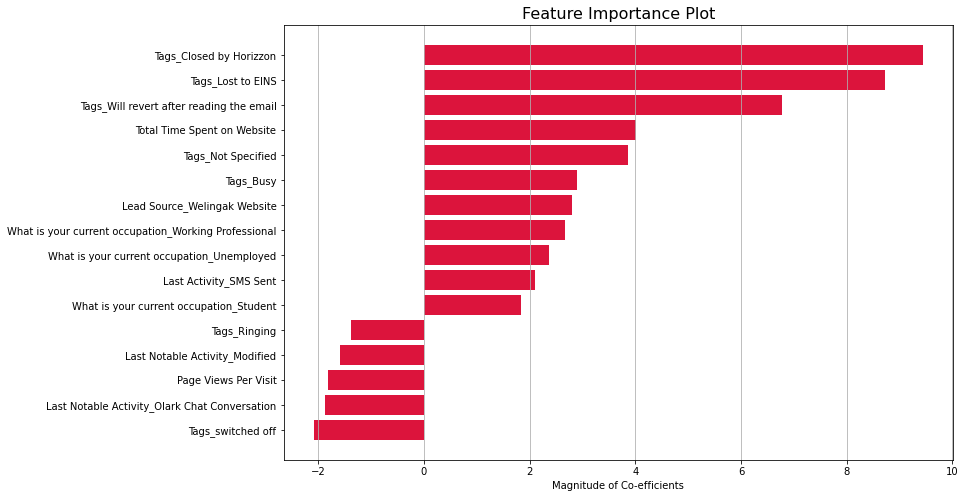

In [120]:
plt.figure(figsize = (12,8))
plt.barh(feature.Features, feature["Co-efficients"], color = 'crimson')
plt.grid(which = 'major', axis = "x")
plt.xlabel("Magnitude of Co-efficients")
plt.title("Feature Importance Plot", fontsize = 16)
plt.show()

**Important variables as per the model:**
   1. Tags
    - Busy
    - Closed by Horizzon
    - Lost to EINS
    - Not Specified
    - Ringing
    - Will revert after reading the email
    - switched off
   2. Total Time Spent on Website
   3. Lead Source
    - Welingak Website
   4. What is your current occupation
    - Student
    - Unemployed
    - Working Professional
   5. Page Views Per Visit
   6. Last Activity
    - SMS Sent
   7. Last Notable Activity
    - Modified
    - Olark Chat Conversation